<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#apply()---Faster-alternatives" data-toc-modified-id="apply()---Faster-alternatives-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>apply() - Faster alternatives</a></span></li><li><span><a href="#Crosstab()---great-for-Heatmaps" data-toc-modified-id="Crosstab()---great-for-Heatmaps-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Crosstab() - great for Heatmaps</a></span></li><li><span><a href="#Window-functions-in-Pandas---using-groupby()" data-toc-modified-id="Window-functions-in-Pandas---using-groupby()-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Window functions in Pandas - using groupby()</a></span><ul class="toc-item"><li><span><a href="#Calculate-cumulative-sum-(running-totals-from-deltas)" data-toc-modified-id="Calculate-cumulative-sum-(running-totals-from-deltas)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Calculate cumulative sum (running totals from deltas)</a></span></li><li><span><a href="#Calculate-deltas" data-toc-modified-id="Calculate-deltas-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate deltas</a></span></li><li><span><a href="#Rank" data-toc-modified-id="Rank-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Rank</a></span></li><li><span><a href="#Aggregate-over-groups-of-rows-(rolling,-avg)" data-toc-modified-id="Aggregate-over-groups-of-rows-(rolling,-avg)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Aggregate over groups of rows (rolling, avg)</a></span></li><li><span><a href="#Aggregate-by-downsampling-the-index-(resample)" data-toc-modified-id="Aggregate-by-downsampling-the-index-(resample)-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Aggregate by downsampling the index (resample)</a></span></li><li><span><a href="#Examples---time-since-first,-time-since-end,-time-since-preceding" data-toc-modified-id="Examples---time-since-first,-time-since-end,-time-since-preceding-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Examples - time since first, time since end, time since preceding</a></span></li></ul></li></ul></div>

In [2]:
import datetime as dt
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.style.use('raph-base')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('precision', 2)
pd.set_option('display.max_columns', 30)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

In [4]:
# Display executable and Python version
print(sys.executable)
print(sys.version)

C:\Users\r2d4\miniconda3\envs\py3\python.exe
3.8.3 (default, May 19 2020, 06:50:17) [MSC v.1916 64 bit (AMD64)]


In [5]:
# Create a dummy frame

size = 10000
cities = ["paris", "barcelona", "berlin", "new york"]
colors = ["red", "green", "blue", "white", "pink"]

df = pd.DataFrame(
    {"city": np.random.choice(cities, size=size),
     "color": np.random.choice(colors, size=size),
     "a_float": np.random.rand(size)}
)

df["id"] = df.index.map(str) + "_" + df["city"]
df = df[["id", "city", "color", "a_float"]]
df.head()

,id,city,color,a_float
0,0_barcelona,barcelona,blue,0.68
1,1_berlin,berlin,blue,0.69
2,2_berlin,berlin,blue,0.18
3,3_paris,paris,white,0.58
4,4_berlin,berlin,blue,0.96


## apply() - Faster alternatives

**Take-aways:** Apply is quite slow, if the operation you want to apply, are vectorizable, use pandas filtering / vectorizing!

In [5]:
def rule(a, b, c):
    if a == "paris" and b in ["yellow", "blue"]:
         return c * 2
    else:
         return 0

%timeit df['new'] = df.apply(lambda x: rule(x["city"], x["color"], x["a_float"]), axis=1)

384 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit

## Alternative

df["new"] = np.NaN
df["new"] = df[(df["city"] == 'new york') & (df["color"].isin(["yellow", "blue"]))]["a_float"] * 2
df["new"].fillna(0, inplace=True)                         

3.54 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


A speed-up of more than x 100

In [7]:
%%timeit

## Now, using np.where()

df["new2"] = np.where(((df["city"] == 'new york') & (df["color"].isin(["yellow", "blue"]))),
                      df["a_float"] * 2,
                      0)

2.04 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Even faster ...

## Crosstab() - great for Heatmaps

- Easy syntax for cross-tables you can also group by multi-index (not shown here)
- Cool is the _normalization_ functionality (all, row-wise, col-wise) and the simple option for adding margins
- ... but a simple groupby().unstack() is faster, if you care for optimized performance

In [8]:
# Simple counts
c_count = pd.crosstab(index=df["city"], columns=df["color"])
c_count

color,blue,green,pink,red,white
city,,,,,
barcelona,516,542,470,510,504
berlin,525,493,490,506,442
new york,505,510,524,496,498
paris,488,475,514,500,492


In [9]:
# Aggregations
c_mean = pd.crosstab(index=df['city'],
                     columns=df['color'],
                     values=df['a_float'],                   
                     aggfunc=np.mean).round(2)
c_mean

color,blue,green,pink,red,white
city,,,,,
barcelona,0.49,0.49,0.50,0.47,0.50
berlin,0.49,0.49,0.52,0.49,0.50
new york,0.49,0.51,0.49,0.51,0.48
paris,0.51,0.51,0.50,0.51,0.47


**Performace** is a little worse than similar groupby().unstack() operations

In [12]:
%%timeit

c_mean = pd.crosstab(index=df['city'],
                     columns=df['color'],
                     values=df['a_float'],                   
                     aggfunc=np.mean).round(2)

13.4 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit

c_mean2 = df.groupby(["city", "color"])["a_float"].mean().round(2).unstack()

4.33 ms ± 97.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Heatmaps** are one main application for crosstab()

In [10]:
def plot_heatmap(cross_table, fmt="g"):
    """'g' param is for int."""
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cross_table,
                annot=True,
                fmt=fmt,
                cmap='rocket_r',
                linewidths=.5,
                square=True,
                ax=ax)
    plt.show();

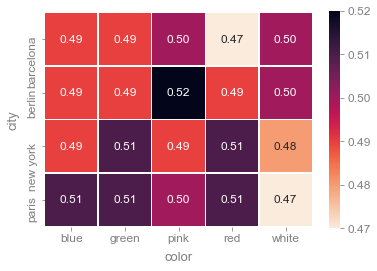

In [15]:
c_mean2 = df.groupby(["city", "color"])["a_float"].mean().round(2).unstack()

plot_heatmap(c_mean2, fmt=".2f")

**Normalize and margin options** are cool!

In [33]:
# Normalize values
c_norm = pd.crosstab(index=df['city'],
                     columns=df['color'],
                     normalize="all") # you can also set "index" or "columns"

c_norm.style.format("{:.1%}")

color,blue,green,pink,red,white
city,,,,,
barcelona,5.2%,5.4%,4.7%,5.1%,5.0%
berlin,5.2%,4.9%,4.9%,5.1%,4.4%
new york,5.1%,5.1%,5.2%,5.0%,5.0%
paris,4.9%,4.8%,5.1%,5.0%,4.9%


In [34]:
# Don't do this not for heatmaps ;-)
c_marg = pd.crosstab(index=df['city'],
                     columns=df['color'],
                     normalize="all",
                     margins=True,
                     margins_name="TOTAL")

c_marg.style.format("{:.1%}")

color,blue,green,pink,red,white,TOTAL
city,,,,,,
barcelona,5.2%,5.4%,4.7%,5.1%,5.0%,25.4%
berlin,5.2%,4.9%,4.9%,5.1%,4.4%,24.6%
new york,5.1%,5.1%,5.2%,5.0%,5.0%,25.3%
paris,4.9%,4.8%,5.1%,5.0%,4.9%,24.7%
TOTAL,20.3%,20.2%,20.0%,20.1%,19.4%,100.0%


## Window functions in Pandas - using groupby()

Mainly following this [blogpost](https://medium.com/jbennetcodes/how-to-get-rid-of-loops-and-use-window-functions-in-pandas-or-spark-sql-907f274850e4) which also provides the PySpark (SQL) equivalents.

_**TO DO:** Check pd.Grouper() check performance on full 10'000 rows._

In [6]:
# Prep: Make a smaller dataframe, include a timestamp column

df_2 = df.iloc[:100, :].copy()
df_2["ts"] = pd.period_range("2020-02-02", periods=100, freq="min").to_timestamp()
df_2["value"] = df_2["a_float"] * 100
df_2.drop(["id", "a_float"], axis=1, inplace=True)

In [115]:
# Check new df
df_2.head()

,city,color,ts,value
0,paris,green,2020-02-02 00:00:00,78.66
1,new york,white,2020-02-02 00:01:00,46.25
2,berlin,red,2020-02-02 00:02:00,61.18
3,berlin,white,2020-02-02 00:03:00,99.43
4,berlin,red,2020-02-02 00:04:00,0.02


### Calculate cumulative sum (running totals from deltas)

cumsum()

In [116]:
# If you want to assign a new col to the input df
df_2["cum_total"] = df_2.sort_values(["ts"]).groupby(["city", "color"])["value"].cumsum()

# Check (and drop again)
df_2.query("city == 'berlin' & color == 'white'")
df_2.drop("cum_total", axis=1, inplace=True)

,city,color,ts,value,cum_total
3,berlin,white,2020-02-02 00:03:00,99.43,99.43
8,berlin,white,2020-02-02 00:08:00,49.90,149.33
19,berlin,white,2020-02-02 00:19:00,22.81,172.14
38,berlin,white,2020-02-02 00:38:00,22.71,194.85
60,berlin,white,2020-02-02 01:00:00,27.91,222.75
68,berlin,white,2020-02-02 01:08:00,62.05,284.80
84,berlin,white,2020-02-02 01:24:00,84.15,368.95
85,berlin,white,2020-02-02 01:25:00,2.41,371.36


In [117]:
# Use df.assign() to assign the new col to a new df object directly
df_out = (df_2.assign(cum_total=df_2.sort_values(["ts"]).groupby(["city", "color"])["value"].cumsum()))

# Check
df_out.query("city == 'berlin' & color == 'white'")

,city,color,ts,value,cum_total
3,berlin,white,2020-02-02 00:03:00,99.43,99.43
8,berlin,white,2020-02-02 00:08:00,49.90,149.33
19,berlin,white,2020-02-02 00:19:00,22.81,172.14
38,berlin,white,2020-02-02 00:38:00,22.71,194.85
60,berlin,white,2020-02-02 01:00:00,27.91,222.75
68,berlin,white,2020-02-02 01:08:00,62.05,284.80
84,berlin,white,2020-02-02 01:24:00,84.15,368.95
85,berlin,white,2020-02-02 01:25:00,2.41,371.36


### Calculate deltas

diff()

In [118]:
df_2["cum_total"] = df_2.sort_values(["ts"]).groupby(["city", "color"])["value"].diff(1)

# # Check (and drop again)
df_2.query("city == 'berlin' & color == 'white'")
df_2.drop("cum_total", axis=1, inplace=True)

,city,color,ts,value,cum_total
3,berlin,white,2020-02-02 00:03:00,99.43,NaN
8,berlin,white,2020-02-02 00:08:00,49.90,-49.53
19,berlin,white,2020-02-02 00:19:00,22.81,-27.09
38,berlin,white,2020-02-02 00:38:00,22.71,-0.10
60,berlin,white,2020-02-02 01:00:00,27.91,5.20
68,berlin,white,2020-02-02 01:08:00,62.05,34.14
84,berlin,white,2020-02-02 01:24:00,84.15,22.09
85,berlin,white,2020-02-02 01:25:00,2.41,-81.74


### Rank

rank(), see [docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rank.html)<br>
If the ranking methods do not suffice (think of PKZ brand segments) go for rankdata from scipy.stats.

In [119]:
df_2["rank"] = (df_2.groupby(["city", "color"])["value"]
                .rank(method='first', ascending=False)
                )

# Check
df_2.query("rank <= 3").sort_values(["city", "color", "rank"]).head(9)
df_2.drop("rank", axis=1, inplace=True)

,city,color,ts,value,rank
90,barcelona,blue,2020-02-02 01:30:00,55.96,1.0
89,barcelona,blue,2020-02-02 01:29:00,28.00,2.0
14,barcelona,green,2020-02-02 00:14:00,86.50,1.0
41,barcelona,green,2020-02-02 00:41:00,71.27,2.0
22,barcelona,green,2020-02-02 00:22:00,67.92,3.0
45,barcelona,pink,2020-02-02 00:45:00,97.37,1.0
52,barcelona,pink,2020-02-02 00:52:00,74.87,2.0
16,barcelona,pink,2020-02-02 00:16:00,72.93,3.0
42,barcelona,red,2020-02-02 00:42:00,54.75,1.0


In [120]:
# And just for fun: all chained in one line
df_alt = (df_2.assign(rank=df_2.groupby(["city", "color"])["value"]
                               .rank(method="first", ascending=False))
                               .query("rank <= 3")
                               .sort_values(["city", "color", "rank"])
                               .head(9))

### Aggregate over groups of rows (rolling, avg)

What makes this a bit more complicated, is that now the order of the rows and so the index is changed during the groupby.<br>
And it is easiest to set the 'ordering column' to index.<br>

Notes: on rolling() params

- The rolling window of size 3 means “current row plus 2 preceding”. (but you could change this order)
- min_periods=1 is to calculate a value even if we have fewer than 3 records in a window (default is different)
- In case you'd want to aggregate with PeriodIndex you'd have to pass additinal parameters.

There is _many_ params to customize rolling(), see `help(df.rolling)`.

In [121]:
# 3-Row-Avg with rolling

# 1. Calculate the new col with the avgs return in a new df
df_avg = df_2.set_index("ts", drop=True)
df_avg = (df_avg.groupby(["city", "color"])
          .rolling(3, min_periods=1)
          .mean()
          .reset_index())


# # Step 2. Merge with original frame (to get original order back)
df_out = df_2.merge(df_avg,
                    on=["city", "color", "ts"],
                    suffixes=("", "_avg3"))

In [122]:
df_out.query("city == 'berlin' & color == 'white'")

,city,color,ts,value,value_avg3
3,berlin,white,2020-02-02 00:03:00,99.43,99.43
8,berlin,white,2020-02-02 00:08:00,49.90,74.67
19,berlin,white,2020-02-02 00:19:00,22.81,57.38
38,berlin,white,2020-02-02 00:38:00,22.71,31.80
60,berlin,white,2020-02-02 01:00:00,27.91,24.47
68,berlin,white,2020-02-02 01:08:00,62.05,37.55
84,berlin,white,2020-02-02 01:24:00,84.15,58.03
85,berlin,white,2020-02-02 01:25:00,2.41,49.53


In [18]:
# Rolling 15 min windows - rolling() with a time-offset, or: resample() with the same time-offset

# 1. Calculate the new col with the avgs return in a new df
df_avg = df_2.set_index("ts", drop=True)
df_avg = (df_avg.groupby(["city", "color"])
          .rolling("15min")  # or: .resample("15min")
          .mean()
          .reset_index())


# Step 2. Merge with original frame (to get original order back)
df_out = df_2.merge(df_avg,
                    on=["city", "color", "ts"],
                    suffixes=("", "_avg15min"))

In [19]:
df_out.query("city == 'berlin' & color == 'white'")

,city,color,ts,value,value_avg15min
5,berlin,white,2020-02-02 00:05:00,74.31,74.31
40,berlin,white,2020-02-02 00:40:00,62.28,62.28
54,berlin,white,2020-02-02 00:54:00,43.98,53.13
60,berlin,white,2020-02-02 01:00:00,97.33,70.65


### Aggregate by downsampling the index (resample)

As seen above resample() can be used for rolling aggregations too. But here we actually want to downsample the index to fixed 15 min intervalls.<br>
Besides the 'classic aproach' there is a much faster alternative using `pd.grouper`. But attention: it only returns intervalls with actual values!

In [162]:
# Classic approach: Actual resampling to fixed 15 min windows - resample()

df_sum = df_2.set_index("ts", drop=True)

# Here now you wrap the groupby().resamle() operation into a DF call
df_sum = pd.DataFrame(df_sum.groupby(["city", "color"]) 
          .resample("15min")["value"]
          .sum()
          ).reset_index()

df_sum.query("city == 'berlin' & color == 'white'")

,city,color,ts,value
39,berlin,white,2020-02-02 00:00:00,149.33
40,berlin,white,2020-02-02 00:15:00,22.81
41,berlin,white,2020-02-02 00:30:00,22.71
42,berlin,white,2020-02-02 00:45:00,0.00
43,berlin,white,2020-02-02 01:00:00,89.96
44,berlin,white,2020-02-02 01:15:00,86.55


In [151]:
# Faster alternative using pd.Grouper

grouper = df_2.groupby([pd.Grouper(freq="15min", key="ts"), "city", "color"])
df_sum = pd.DataFrame(grouper["value"].sum()).reset_index()

df_sum.query("city == 'berlin' & color == 'white'")

,ts,city,color,value
4,2020-02-02 00:00:00,berlin,white,149.33
14,2020-02-02 00:15:00,berlin,white,22.81
25,2020-02-02 00:30:00,berlin,white,22.71
45,2020-02-02 01:00:00,berlin,white,89.96
57,2020-02-02 01:15:00,berlin,white,86.55


**Attention:**  One intervall is missing because there were no values. This behaviour can lead to problems depending on the use case (remember kpi app ...)

... but the speed gains might be worth it:

In [155]:
# Use 10000 rows for comparison
df_3 = df.iloc[:10000, :].copy()
df_3["ts"] = pd.period_range("2020-02-02", periods=10000, freq="min").to_timestamp()
df_3["value"] = df_3["a_float"] * 100
df_3.drop(["id", "a_float"], axis=1, inplace=True)

In [156]:
%%timeit  # classic resample

df_sum = df_3.set_index("ts", drop=True)
df_sum = pd.DataFrame(df_sum.groupby(["city", "color"]) 
          .resample("15min")["value"]
          .sum()
          ).reset_index()

57.3 ms ± 529 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [161]:
%%timeit  # pd.Grouper is much faster

grouper = df_2.groupby([pd.Grouper(freq="15min", key="ts"), "city", "color"])
df_sum = pd.DataFrame(grouper["value"].sum()).reset_index()

4.18 ms ± 89.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Examples - time since first, time since end, time since preceding

The resulting col is in Timedelta format

In [28]:
# Time since first visit (not sort=False helps with performance)

df_out = df_2.assign(time_since_first=df_2.groupby(
    ["city", "color"], sort=False)
    ["ts"].apply(lambda x: x - x.min()))

df_out.query("city == 'berlin' & color == 'white'")

,city,color,ts,value,time_since_first
5,berlin,white,2020-02-02 00:05:00,74.31,00:00:00
40,berlin,white,2020-02-02 00:40:00,62.28,00:35:00
54,berlin,white,2020-02-02 00:54:00,43.98,00:49:00
60,berlin,white,2020-02-02 01:00:00,97.33,00:55:00


In [32]:
# Time since "end of period" (recency)

end = df_2["ts"].max()
print("End time:", end)

df_out = df_2.assign(recency=df_2.groupby(
                     ["city", "color"], sort=False)
                     ["ts"].apply(lambda x: end - x))

df_out.query("city == 'berlin' & color == 'white'")

End time: 2020-02-02 01:39:00


,city,color,ts,value,recency
5,berlin,white,2020-02-02 00:05:00,74.31,01:34:00
40,berlin,white,2020-02-02 00:40:00,62.28,00:59:00
54,berlin,white,2020-02-02 00:54:00,43.98,00:45:00
60,berlin,white,2020-02-02 01:00:00,97.33,00:39:00


In [67]:
# Time since last / preceding visit (delta)

df_out = df_2.assign(time_since_last=df_2.groupby(
                     ["city", "color"])["ts"].diff(1))

df_out.query("city == 'berlin' & color == 'white'")

,city,color,ts,value,time_since_last
5,berlin,white,2020-02-02 00:05:00,74.31,NaT
40,berlin,white,2020-02-02 00:40:00,62.28,00:35:00
54,berlin,white,2020-02-02 00:54:00,43.98,00:14:00
60,berlin,white,2020-02-02 01:00:00,97.33,00:06:00


In [44]:
%%timeit

# Time since last / preceding visit (delta)
df_out = df_2.assign(time_since_last=df_2.groupby(
                     ["city", "color"])["ts"].diff(-1))

5.56 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
%%timeit

df_out = df_2.assign(time_since_last=df_2.groupby(
                     ["city", "color"])["ts"].apply(lambda x: x - x.shift(-1)))

8.88 ms ± 72.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
